# Lab 1
In this notebook, we use the following modules `numpy` and `maze`. The latter is a modification of the `maze` provided as solution to lab0.

In [1]:
import numpy as np
import maze as mz

# Problem 1: The Maze and the Minotaur

The objective of problem 1 is to leave the maze as quickly as possible without being eaten. We start first by describing the maze as a numpy array. 

In [2]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]
])
# with the convention 
# 0 = empty cell
# 1 = obstacle
# 2 = exit of the Maze

The method `maze.draw_maze()` helps us draw the maze given its numpy array discription.  

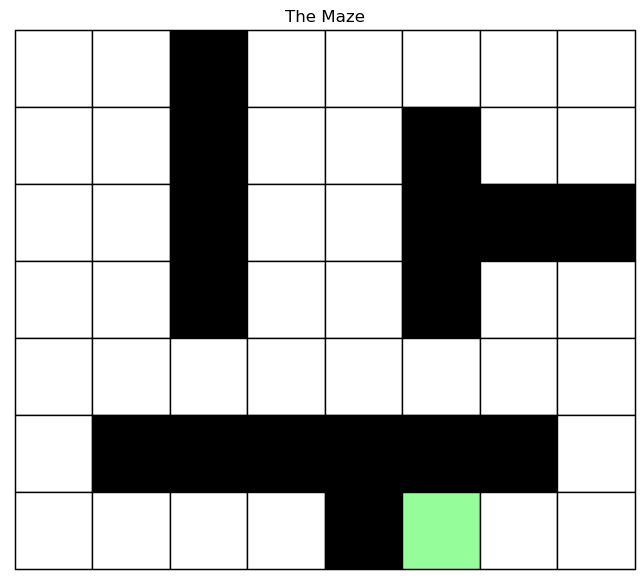

In [3]:
mz.draw_maze(maze)

## 1.a) MDP formulation

We propose the following MDP formulation: 

#### State space $\mathcal{S}$
We model the state space as the set of all possible positions of the player and the minotaur in the maze. Note that we exclude state where the player's position is an obstacle since these are impossible states to be in for the player. Formally, the state space is

$$\mathcal{S} = \big\lbrace ((i,j),(k,l)):\textrm{such that the cell
} (i,j) \textrm{ is not an obstacle}\big\rbrace.$$

#### Action space $\mathcal{A}$
We allow the player to chose to either move `left`, `right`, `down`, `up` or not move at all (`stay`). Note that sometimes the player cannot move in a certain direction because of an obstacle or a wall, yet we permit this to be a possible action. We will see that this is not an issue as long as we define our transition probabilities and rewards appropriately.
Formally, the action space is

$$\mathcal{A} = \lbrace \textrm{up}, \textrm{ down}, \textrm{ left}, \textrm{ right}, \textrm{ stay} \rbrace.$$
> **Note:** Once again, the choice of the action space is not unique. For instance one could remove the action `stay` from $\mathcal{A}$, but then one should modify the transition probabilities accordingly as well as the rewards.  


#### Transition probabilities $\mathcal{P}$
Note that there is randomness involved due to the movements of the minotaur.
- If in some state $s=((i,j),(k,l))$ the Minotaur and Player position are the same, i.e., $(i,j)=(k,l)$, the player is eaten and thus the game ended and noone will move anymore, then $\mathbb{P}(s \vert s, a) = 1$.
- If in some state $s=((i,j),(k,l))$ the Minotaur and the player are not in the same position but the player is at the goal position, i.e., $B=(i,j)\ne(k,l)$, the player one and thus the game ended and noone will move anymore, then $\mathbb{P}(s \vert s, a) = 1$.
- If at state $s=((i,j),(k,l))$ we are neither eaten nor at a goal state, i.e., $B\ne(i,j)\ne(k,l)$:
   - If taking action (or move) $a$ does not lead to a wall or an obstacle, then the player position afterward will be $(i',j')\ne(i,j)$. 
   - If, however, taking action (or move) $a$ leads to a wall or an obstacle, the player remains in his position, i.e., $(i',j')=(i,j)$. 
   - Additionally, let $(k'_h, l'_h), h=1,...,n$ be the $n$ different positions to which the minotaur can move without moving into a wall or staying at the same position, but with moving into obstacles. Then $n=2$ for corners, $n=3$ for edges, and $n=4$ else.
   - Then let $s'_h=((i',j'),(k'_h,l'_h)), h=1,...,n$ be the different states we can end up in. Those will all have the same probability, i.e., $\mathbb{P}(s'_h \vert s, a) = \frac{1}{n}, h=1,...,n$.


> **Note**: Recall that for a fixed $s \in \mathcal{S}$ and $a \in \mathcal{A}$ we have $\sum_{s' \in \mathcal{S}} \mathbb{P}(s' \vert s, a) = 1$, thus for all $s' \in \mathcal{S}$, $s \in \mathcal{S}$ and $a \in \mathcal{A}$ not covered above, we have $\mathbb{P}(s' \vert s, a) = 0$.

#### Rewards $\mathcal{R}$
The objective of the player is to find the exit of the maze while avoiding the obstacles.   
   - If at state $s$ we are eaten, the reward for all actions $a$ is $r(s,a) = -\infty$
   - If at state $s$ we are not eaten but at the exit, the reward for all actions $a$ is $r(s,a) = 0$
   - If at state $s$, taking action $a$, leads to a wall or an obstacle then $r(s,a) = -\infty$
   - If at state $s$, taking action $a$, leads to some other position in the maze that is not the exit nor a wall nor an obstacle, then $r(s, a) = -1$.
> **Note**: Here the rewards are independent of time (i.e. $r_t(.,.) = r(.,.)$). 


### Implementation
The above MDP formulation is implemented as a class ``maze.Maze`` in the file [maze.py](./maze.py) which given a matrix description of the maze instanciates the state space, action space, transition probabilities and rewards. 

> **Note:** In the class `maze.Maze` each state $s = ((i,j),(k,l))$ is given a unique identifier $s_{id} \in \lbrace 0, , \dots, \vert S \vert -1 \rbrace$. In other words, the state space from an implementation perspective is viewed as the set of integers $\lbrace 0, , \dots, \vert S \vert -1 \rbrace$. This mapping is done via the dictionary `self.map` and its inverse mapping via the dictionary `self.states`.   

## 1.b) Alternative MDP formulation when not moving simultaneously (Player moves first)
The difference is that when moving into the exit or into the minotaur, the minotaur won't take a step afterward.

More formally, if in state $s=((i,j),(k,l))$ where $B\ne(i,j)\ne(k,l)$ (neither at exit nor eaten) and taking action $a$, where $a$ is an allowed action that leads to $(i',j')\ne(i,j)$ with either moving into the minotaur $(i',j')=(k,l)$ or reaching the exit $B=(i',j')$, the minotaur will not take another move.

I.e., the probability of reaching state $s'=((i',j'),(k,l))$ will be $\mathbb{P}(s' \vert s, a) = 1$ and the probability of reaching any other state $s''\ne s'$ will be $\mathbb{P}(s'' \vert s, a) = 0$.

Everything else is as before.

In [20]:
# Simulate the shortest path starting from position A
def monte_carlo(env, policy, n):
    method = 'DynProg';
    start  = (0,0);
    n_win = 0
    n_eaten = 0
    n_else = 0
    for i in range(n):
        path = env.simulate(start, policy, method);
        end_state = path[-1]
        if env.win(env.map[end_state]):
            n_win += 1
        elif env.eaten(env.map[end_state]):
            n_eaten += 1
        else:
            n_else += 1
    return n_win, n_eaten, n_else

In [13]:
def compare_simultaneous(maze, horizon, n):
    print("simultaneous")
    env = mz.Maze(maze)
    V, policy = mz.dynamic_programming(env, horizon)
    n_win, n_eaten, n_else = monte_carlo(env, policy, n)
    print("win: ", n_win/n)
    print("eaten: ", n_eaten/n)
    print("else: ", n_else/n)

    print("not simultaneous")
    env = mz.Maze(maze, simultaneous=False)
    V, policy = mz.dynamic_programming(env,horizon);
    n_win, n_eaten, n_else = monte_carlo(env, policy, n)
    print("win: ", n_win/n)
    print("eaten: ", n_eaten/n)
    print("else: ", n_else/n)

In [14]:
horizon = 20
n = 1000
compare_simultaneous(maze, horizon, n)

simultaneous
win:  1.0
eaten:  0.0
else:  0.0
not simultaneous
win:  0.807
eaten:  0.0
else:  0.193


In [18]:
horizon = 10
n = 100
compare_simultaneous(maze, horizon, n)

simultaneous
win:  0.0
eaten:  0.0
else:  1.0
not simultaneous
win:  0.0
eaten:  0.0
else:  1.0


In [19]:
horizon = 300
n = 10
compare_simultaneous(maze, horizon, n)

simultaneous
win:  1.0
eaten:  0.0
else:  0.0
not simultaneous
win:  1.0
eaten:  0.0
else:  0.0


## 1.c) - Dynamic Programming

In [12]:
# Create an environment maze
env = mz.Maze(maze)
# env.show()

##  Dynamic Programming 

Before solving the MDP problem, recall that the finite horizon objective function is 
$$
    \mathbb{E} \Big[ \sum_{t=0}^T r(s_t, a_t) \Big],
$$
where $T$ is the horizon.
Recall the Bellman equation 
\begin{equation}
\forall s \in \mathcal{S} \qquad  V(s) = \max_{a \in \mathcal{A}} \Big\lbrace r(s,a) + \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,a) V(s') \Big\rbrace
\end{equation}
The dynamic programming solution for the finite horizon MDP problem consists of solving the above backward recursion. The method `maze.dynamic_programming` achieves this. 
> **Note:** To find the optimal path, it is enough to set the time horizon $T = 10$. Indeed, looking at the maze one can see that the player needs at least 10 steps to attain the exit $B$, if her starting position is at $A$. In fact if you set the time horizon less than 10, you will see that you do not find the optimal path.



In [13]:
# Finite horizon
horizon = 20
# Solve the MDP problem with dynamic programming 
V, policy = mz.dynamic_programming(env,horizon);

In [14]:
# Simulate the shortest path starting from position A
method = 'DynProg';
start  = (0,0);
path = env.simulate(start, policy, method);
path

[((0, 0), (6, 5)),
 ((0, 1), (6, 4)),
 ((1, 1), (6, 5)),
 ((2, 1), (6, 4)),
 ((3, 1), (6, 3)),
 ((4, 1), (5, 3)),
 ((4, 2), (6, 3)),
 ((4, 3), (5, 3)),
 ((4, 4), (5, 2)),
 ((4, 5), (4, 2)),
 ((4, 6), (5, 2)),
 ((4, 7), (4, 2)),
 ((5, 7), (3, 2)),
 ((6, 7), (3, 3)),
 ((6, 6), (2, 3)),
 ((6, 5), (1, 3)),
 ((6, 5), (1, 3)),
 ((6, 5), (1, 3)),
 ((6, 5), (1, 3)),
 ((6, 5), (1, 3)),
 ((6, 5), (1, 3))]

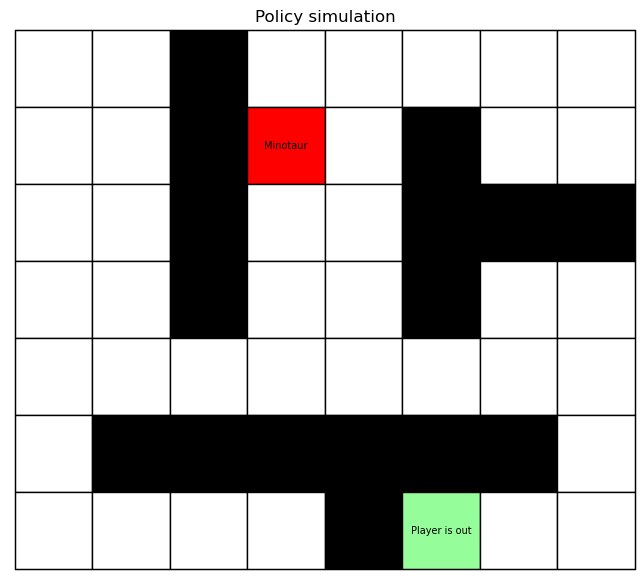

In [15]:
# Show the shortest path 
mz.animate_solution(maze, path)

## 1.d) Minotaur can stay

In [40]:
def compare_minotaur_can_stay(maze, max_T, n):
    env1 = mz.Maze(maze)
    env2 = mz.Maze(maze, minotaur_can_stay=True)

    outcomes = []
    for T in range(1, max_T+1):

        V, policy = mz.dynamic_programming(env1, T)
        n_win, n_eaten, n_else = monte_carlo(env1, policy, n)
        p_1 = [n_win, n_eaten, n_else]

        V, policy = mz.dynamic_programming(env2,T)
        n_win, n_eaten, n_else = monte_carlo(env2, policy, n)
        p_2 = [n_win, n_eaten, n_else]

        outcomes.append([p_1, p_2])
    return np.array(outcomes) / n

In [46]:
horizon = 20
outcomes = compare_minotaur_can_stay(maze, 30, 100)

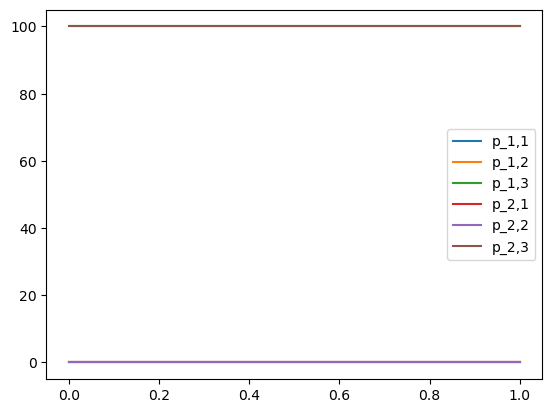

In [ ]:
import matplotlib.pyplot as plt
for i in range(2):
    for j in range(3):
        plt.plot(outcomes[:,i,j], label="p_{},{}".format(i+1, j+1))
plt.legend()
plt.show()

## Value Iteration

Here we solve the discounted infinite-horizon MDP problem using value iteration, the objective here is to find a stationary policy $\pi$ that minimizes the infinite horizon objective with a discount factor $\gamma$ 
$$
    \mathbb{E} \Big[\sum_{t=0}^\infty \gamma^t r\big(s_t, \pi(s_t)\big) \Big].
$$
Recall the Bellman equation in the case of a stationary policy $\pi$ 
\begin{equation}
\forall s \in \mathcal{S} \qquad  V^*(s) = \max_{\pi} \Big\lbrace r(s,\pi(s)) + \gamma \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,\pi(s)) V^*(s') \Big\rbrace
\end{equation}
or equivalently in terms of the Bellman operator $\mathcal{L}$ 
\begin{equation}
V^* =  \mathcal{L}(V^*)
\end{equation}
where 
\begin{equation}
   \forall s \in \mathcal{S} \qquad  \mathcal{L}(V)(s) = \max_{\pi} \Big\lbrace r(s,\pi(s)) + \gamma \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,\pi(s)) V(s') \Big\rbrace. 
\end{equation}
Value iteration solves the Bellman equation described above. This method is implemented as `maze.value_iteration` in the file [maze.py]().

> **Note:** Recall that the mapping $\mathcal{L}$ is a contraction, therefore value iteration converges. To achieve an $\varepsilon>0$ approximation (i.e. $\Vert V^* - V_{n+1} \Vert \le \varepsilon$),
 the stopping criterion of value iteration is $\Vert V - \mathcal{L}(V) \Vert < \frac{1-\gamma}{\gamma}\varepsilon$.

In [21]:
# Discount Factor 
gamma   = 0.95; 
# Accuracy treshold 
epsilon = 0.001;
V, policy = mz.value_iteration(env, gamma, epsilon)

In [22]:
method = 'ValIter';
start  = (0,0);
path = env.simulate(start, policy, method)
path

[((0, 0), (5, 5)),
 ((1, 0), (5, 4)),
 ((2, 0), (5, 5)),
 ((3, 0), (5, 4)),
 ((4, 0), (5, 3)),
 ((5, 0), (5, 2)),
 ((5, 0), (5, 1)),
 ((5, 1), (4, 1)),
 ((5, 2), (3, 1)),
 ((5, 3), (4, 1)),
 ((5, 4), (4, 0)),
 ((5, 5), (4, 1)),
 ((5, 5), (4, 1))]

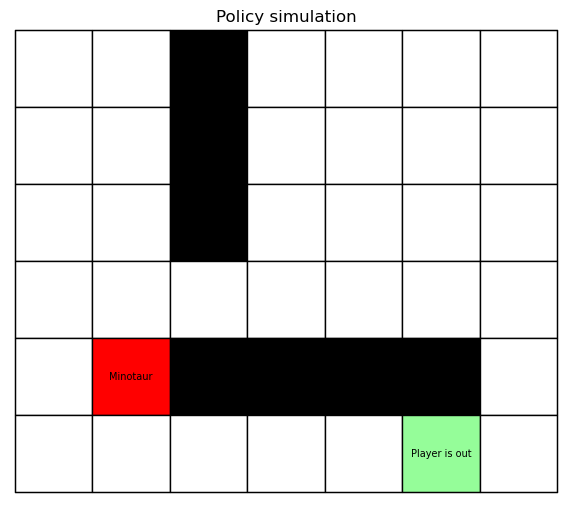

In [23]:
# Show the shortest path 
mz.animate_solution(maze, path)

## Random rewards 

### The new MDP formulation 
As stated in the problem statement, we only modify the rewards $\mathcal{R}$ to be random. In fact we will only need to modify the rewards corresponding to the state action pair $(s,a)$ that lead to either the cell R1 or R2.
#### Rewards $\mathcal{R}$
The objective of the player is to find the exit of the maze while avoiding the obstacles.    
   - If at state $s$, taking action $a$, leads to the cell R1 then the reward is random according to the following     
   $$ R(s,a) = \begin{cases}
            -7 \quad \textrm{ w.p. } 0.5 \\
            -1 \quad \textrm{ w.p. } 0.5
            \end{cases} 
     $$
   - If at state $s$, taking action $a$, leads to the cell R2 then the reward is random according to the following 
     $$ R(s,a) = \begin{cases}
            -2 \quad \textrm{ w.p. } 0.5 \\
            -1 \quad \textrm{ w.p. } 0.5
            \end{cases} 
     $$
   - The remaining rewards remain deterministic and with the same values as in the previous formulation.

> **Note**: The fact that you stay in a cell for a number of rounds $n$ means that you are forced to incur the reward of ending up in that state for an additional $n$ times. Thus, instead of modifying the transition probabilities, we can modify the reward of ending up at that round by multiplying it by $n + 1$.  

### Solving the new MDP 
As mentioned in the appendix [random_rewards.pdf]() (see in canvas), when solving the problem we will only have to look at the average rewards instead of the realization of the rewards, and the methods implemented for the previous case remain unchanged.  

> **Note**: In the implementation, the only change will be the rewards. In addition, the policies we obtain remain deterministic. However, when running a policy the accumulated reward is random, but its average over multiple repetitions should converge to the value function. 

In [24]:
# Description of the maze as a numpy array
maze = np.array([
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 0, 0, 0, 0, -1],
    [ 0, 1, 1, 1, 1, 1,  0],
    [-6, 0, 0, 0, 0, 2,  0]
])
# with the convention 
#  0 = empty cell
#  1 = obstacle
#  2 = exit of the Maze
# -n = trapped cell with probability 0.5. If the cell is trapped the player must stay there for n times.  

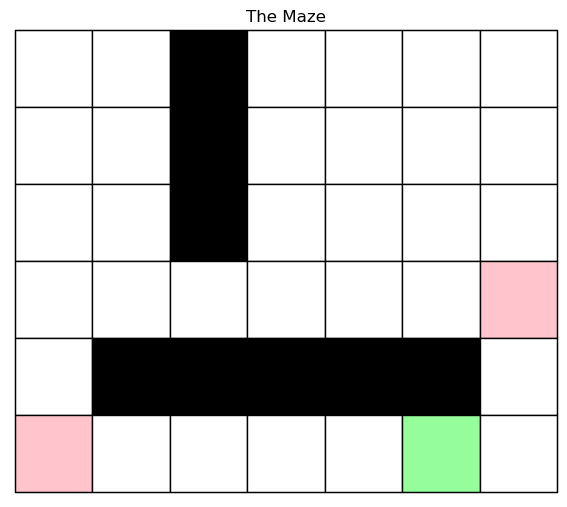

In [25]:
mz.draw_maze(maze);

### Dynamic programming 

Run the following python code to obtain the optimal solution of the newly formulated MDP with dynamic programming. 

In [26]:
# Create an environment maze
env = mz.Maze(maze, random_rewards=True)
# env.show()

In [27]:
# Finite horizon
horizon = 15
# Solve the MDP problem with dynamic programming 
V, policy= mz.dynamic_programming(env,horizon);
# Simulate the shortest path starting from position A
method = 'DynProg';
start  = (0,0);
path = env.simulate(start, policy, method);
path

[((0, 0), (5, 5)),
 ((1, 0), (5, 6)),
 ((2, 0), (4, 6)),
 ((2, 1), (5, 6)),
 ((3, 1), (5, 5)),
 ((3, 2), (4, 5)),
 ((3, 3), (5, 5)),
 ((3, 4), (5, 4)),
 ((3, 5), (4, 4)),
 ((3, 6), (3, 4)),
 ((4, 6), (2, 4)),
 ((5, 6), (1, 4)),
 ((5, 5), (1, 3)),
 ((5, 5), (1, 3)),
 ((5, 5), (1, 3)),
 ((5, 5), (1, 3))]

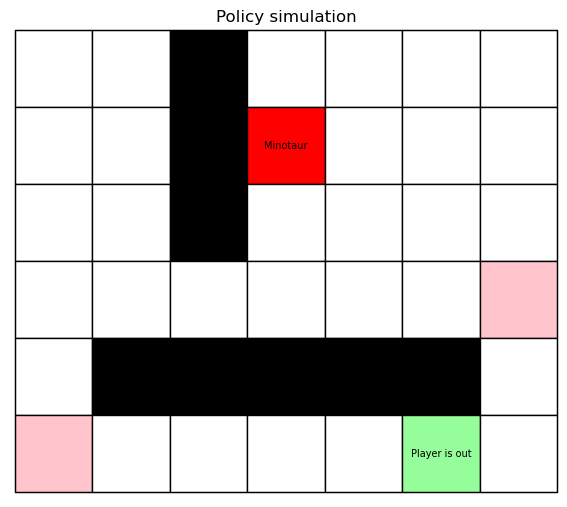

In [28]:
# Show the shortest path 
mz.animate_solution(maze, path)

> **Note:** The animation does not illustrate the event where the player is trapped as it assumes average rewards. Nonetheless, the shown policy is the optimal one.     

### Value iteration  

Run the following python code to obtain the optimal solution of the newly formulated MDP with value iteration.

In [29]:
# Discount Factor 
gamma   = 0.95; 
# Accuracy treshold 
epsilon = 0.0001;
V, policy = mz.value_iteration(env, gamma, epsilon)

method = 'ValIter';
start  = (0,0);
path = env.simulate(start, policy, method)
path

[((0, 0), (5, 5)),
 ((0, 1), (5, 6)),
 ((1, 1), (5, 5)),
 ((2, 1), (5, 6)),
 ((3, 1), (4, 6)),
 ((3, 2), (3, 6)),
 ((3, 3), (2, 6)),
 ((3, 4), (3, 6)),
 ((3, 4), (4, 6)),
 ((3, 5), (4, 5)),
 ((3, 6), (5, 5)),
 ((4, 6), (4, 5)),
 ((5, 6), (3, 5)),
 ((5, 5), (3, 4)),
 ((5, 5), (3, 4))]

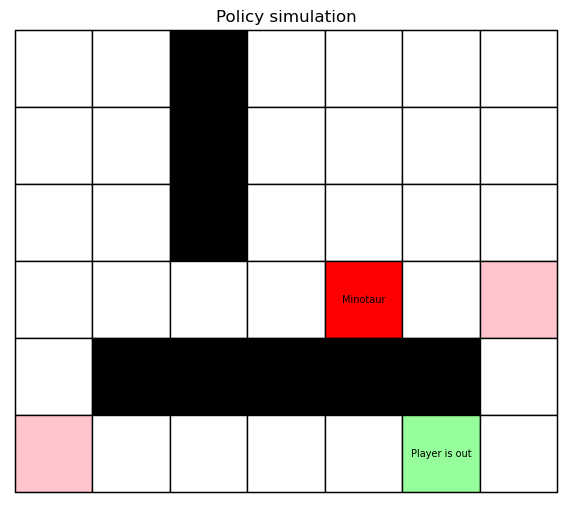

In [30]:
# Show the shortest path 
mz.animate_solution(maze, path)

# Problem 2 : Plucking berries

### The new MDP formulation 

In this problem, the introduction of weights is translated in our previous MDP formulation by a modification of the rewards $\mathcal{R}$. This is done by simply setting $r(s,a)$ to $w_{ij}$ if being in state $s$ and taking action $a$ leads to being in th new state $s'=(i,j)$. 

In [31]:
# Description of the maze as a numpy array
maze = np.array([
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 0, 0, 0, 0,  0],
    [ 0, 1, 1, 1, 1, 1,  0],
    [ 0, 0, 0, 0, 0, 2,  0]
])

# Description of the weight matrix as a numpy array
w = np.array([
    [0,    1, -100,   10,   10,   10, 10],
    [0,    1, -100,   10,    0,    0, 10],
    [0,    1, -100,   10,    0,    0, 10],
    [0,    1,    1,    1,    0,    0, 10],
    [0, -100, -100, -100, -100, -100, 10],
    [0,    0,    0,    0,    0,   11, 10]
])

In [32]:
# Create an environment maze
env = mz.Maze(maze, weights=w)
# env.show()

### Dynamic programming 

Run the following python code to obtain the optimal solution of the newly formulated MDP with dynamic programming.

In [33]:
# Finite horizon
horizon = 20
# Solve the MDP problem with dynamic programming 
V, policy = mz.dynamic_programming(env,horizon);
# Simulate the shortest path starting from position A
method = 'DynProg';
start  = (0,0);
path = env.simulate(start, policy, method);
print(path)

[((0, 0), (5, 5)), ((0, 1), (5, 4)), ((1, 1), (4, 4)), ((2, 1), (3, 4)), ((3, 1), (4, 4)), ((3, 2), (3, 4)), ((3, 2), (3, 3)), ((3, 3), (3, 2)), ((2, 3), (2, 2)), ((1, 3), (2, 1)), ((0, 3), (2, 0)), ((0, 4), (3, 0)), ((0, 5), (4, 0)), ((0, 6), (4, 1)), ((1, 6), (4, 0)), ((2, 6), (5, 0)), ((3, 6), (5, 1)), ((4, 6), (5, 0)), ((5, 6), (4, 0)), ((5, 5), (4, 1)), ((5, 5), (4, 1))]


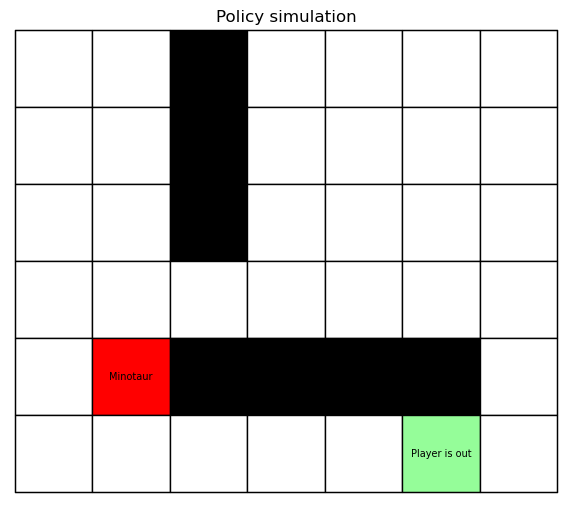

In [34]:
# Show the shortest path 
mz.animate_solution(maze, path)

> **Note:** By changing the horizon from $20$ to $12$ you should observe that the optimal policy changes.  

### Value iteration  

Run the following python code to obtain the optimal solution of the newly formulated MDP with value iteration.

In [35]:
# Discount Factor 
gamma   = 0.50; 
# Accuracy treshold 
epsilon = 0.001;
V, policy = mz.value_iteration(env, gamma, epsilon)
method = 'ValIter';
start  = (0,0);
path = env.simulate(start, policy, method)
path

[((0, 0), (5, 5)),
 ((0, 1), (5, 6)),
 ((1, 1), (4, 6)),
 ((2, 1), (3, 6)),
 ((3, 1), (2, 6)),
 ((3, 2), (3, 6)),
 ((3, 3), (3, 5)),
 ((2, 3), (3, 6)),
 ((1, 3), (4, 6)),
 ((0, 3), (5, 6)),
 ((0, 4), (4, 6)),
 ((0, 5), (3, 6)),
 ((0, 6), (3, 5)),
 ((1, 6), (3, 4)),
 ((2, 6), (3, 3)),
 ((3, 6), (2, 3)),
 ((4, 6), (2, 2)),
 ((5, 6), (2, 3)),
 ((5, 5), (2, 2)),
 ((5, 5), (2, 2))]

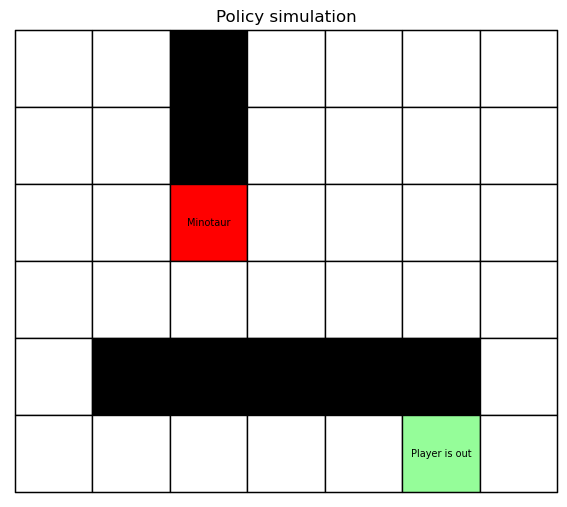

In [36]:
# Show the shortest path 
mz.animate_solution(maze, path)